# Prediction of Stock Prices

## Overview
The idea here is to try and predict the price on 1st September 2024 (Well 3rd Septemebr at thats the monday). The only price we require is the price from 1 year previous to the prediction date. This is because we are trying to simualate a long term (12-months) price target/recommendation.
The model will de trained on all data up to 1st September 2023 and then it will be asked to predict the price for the furture!

In this notebook I will evaluate a subset of tech stocks AAPL(Apple), AMZN(Amazon), GOOG(Google) and META (Meta). I will evaluate different Machine Learning Models by only using the historical prices for each stock. 
Once the notebook has produced results I will evaluate them and then choose my implementation. Finally I will then use Bayesian Optimisation to choose the best parameters for my model.

## Data files 
* ./data/price_targets.xlsx - A list of price targets for target date 1st September 2024
* ./data/price_history.xlsx - 5.5 years of historical stock prices
* ./stock_news.xlsx - A list of news articles about each company over the past few years (not very comprehensive but the best I could obtain for free)

## Notebook Structure

1) Import all relevant 3rd party modules for evaluation models
2) Create an Excel file with average daily sentiment scores for each symbol
3) Evaluate different models using only price data and find the best
4) Create a new model for each symbol and evaluate the preformance against analyst predictions

In [1]:
import os
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime as dt
from datetime import datetime
import nltk
import numpy as np
from sklearn.linear_model import BayesianRidge,LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from IPython.display import display
import xgboost as xgb
from bayes_opt import BayesianOptimization


## First obtain the sentiment analysis for each company

In [2]:
# Download VADER lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\trevo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Load the Excel file 

In [3]:
news_file_path = './data/stock_news.xlsx'  # Replace with your file path
news_df = pd.read_excel(news_file_path)

### Initialize the VADER sentiment analyzer

In [4]:
sid = SentimentIntensityAnalyzer()

### Create a function to apply VADER sentiment analysis to the summary column

In [5]:
def get_sentiment_score(summary):
    sentiment = sid.polarity_scores(summary)
    return sentiment['compound']

### Format the dataframe

In [6]:
news_df['publishedOn'] = pd.to_datetime(news_df['publishedOn']).dt.date
# Apply the sentiment analysis function to the 'summary' column
news_df['sentiment_score'] = news_df['summary'].apply(get_sentiment_score)

### Group by 'symbol' and 'publishedOn' and calculate the average sentiment score

In [7]:
avg_sentiment = news_df.groupby(['symbol', 'publishedOn'])['sentiment_score'].mean().reset_index()

### Save the sentiment result to a new Excel file

In [8]:
sentiment_file_path = './data/average_sentiment_by_symbol_date.xlsx'
avg_sentiment.to_excel(sentiment_file_path, index=False)
print(f"Average sentiment scores saved to {sentiment_file_path}")

Average sentiment scores saved to ./data/average_sentiment_by_symbol_date.xlsx


# Evaluate the models without sentiment and bayesian optimisation


### First set up the parameters and files used in all model evaluations

In [9]:
# Load the dataset, historical prices can be found on a number of providers websites e.g. yahoo finance
price_history_file_path = './data/price_history.xlsx'  # Replace with your file path
df = pd.read_excel(price_history_file_path)

# Load the price/analysts targets file
price_targets_file_path = './data/price_targets.xlsx'
price_targets_df = pd.read_excel(price_targets_file_path)
analyst_targets = price_targets_df.set_index('symbol')['target_price'].to_dict()

# Set up date parameters
df['close_price_date'] = pd.to_datetime(df['close_price_date'])
df['day_of_week'] = df['close_price_date'].dt.dayofweek
df['month'] = df['close_price_date'].dt.month
df['year'] = df['close_price_date'].dt.year

# Date to predict: 1st September 2024
predict_date = pd.Timestamp('2024-09-03')

# Select features for training
features = ['day_of_week', 'month', 'year', 'previous_close_price']

# Train and predict for each stock symbol
symbols = df['symbol'].unique()

# Set a variable for a training cutoff date, in this case its one year before our prediction
# the same as the human analysts would have
train_cutoff_date = pd.Timestamp('2023-09-01')

## Define the format_percentage function for outputing results

In [10]:
def format_percentage(value):
    return "{:.2f}%".format(value) if value is not None else "N/A"

## Extract the previous close price from the  data

In [11]:
def get_last_available_previous_price(symbol_df):
    return symbol_df[symbol_df['close_price_date'] == symbol_df['close_price_date'].max()]['close_price'].values[0]

### Evaluate using a Randomized searchCV model to predict prices based only on historic prices

In [12]:
searchCV_results = []

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [10, 20, 30, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['sqrt', 'log2', 0.5],
    'bootstrap': [True, False],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.1],
    'criterion': ['squared_error', 'absolute_error'],
    'oob_score': [True, False]
}

param_dist_with_max_samples = {
    'bootstrap': [True],
    'max_samples': [0.5, 0.75, 1.0]
}

# Set cutoff date for training data
df_train = df[df['close_price_date'] < train_cutoff_date]

# Loop through each stock symbol
for symbol in symbols:
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Create 'previous_close_price' feature and drop rows with NaN values
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target variable
    #features = ['day_of_week', 'month', 'year', 'previous_close_price']  # Adjust this as needed
    X = df_symbol[features]
    y = df_symbol['close_price']

    # Split the data into training and test sets (no shuffle to preserve time-series order)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Normalize the input features
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)

    # Initialize RandomForest and RandomizedSearchCV
    rf = RandomForestRegressor(random_state=42)

    rf_random = RandomizedSearchCV(estimator=rf,
                                   param_distributions={**param_dist, **param_dist_with_max_samples},
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

    # Train the model
    print(f"Training RandomForest model with tuning for {symbol}...")
    rf_random.fit(X_train_norm, y_train)

    # Get the last available previous close price for the stock
    last_close_price = df_symbol['previous_close_price'].iloc[-1]

    # Prepare input data for future prediction (e.g., for 1st September 2024)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })

    # Normalize the input features for prediction
    predict_data_norm = scaler.transform(predict_data)

    # Predict the price for 1st September 2024
    predicted_price = rf_random.best_estimator_.predict(predict_data_norm)[0]

    # Get the actual close price for 1st September 2024, if available in the dataset
    actual_price = df.loc[(df['symbol'] == symbol) & (df['close_price_date'] == predict_date), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    # Calculate percentage differences if actual price is available
    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results for this symbol
    searchCV_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

print(searchCV_results)

Training RandomForest model with tuning for AAPL...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for GOOG...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for META...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Training RandomForest model with tuning for AMZN...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[{'symbol': 'AAPL', 'target_date': '03/09/2024', 'predicted_price': 170.77434999999892, 'analyst_target_price': 198, 'actual_price': 222.77, 'predicted_percent_diff': -23.340508147417108, 'analyst_percent_diff': -11.119091439601386}, {'symbol': 'GOOG', 'target_date': '03/09/2024', 'predicted_price': 131.5871875, 'analyst_target_price': 140, 'actual_price': 158.61, 'predicted_percent_diff': -17.037269087699396, 'analyst_percent_diff': -11.733182018788229}, {'symbol': 'META', 'target_date': '03/09/2024', 'predicted_price': 294.102834797

### Evaluate using a Polynominal Regression model to predict prices based only on historic prices
### No training cut off in this one, its purely for a comparison

In [13]:
# Train and predict for each stock symbol
polynom_results = []

# Polynomial regression for each stock
for symbol in symbols:
    # Filter data for the current symbol
    df_symbol = df[df['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Create polynomial features for prediction
    predict_data_poly = poly.transform(predict_data)
    predict_data_scaled = scaler.transform(predict_data_poly)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

    # Get the actual close price for 1st September 2024, if available in the dataset
    actual_price = df_symbol[df_symbol['close_price_date'] == predict_date]['close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    polynom_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Evaluate using a Polynominal Regression model to predict prices based only on historic prices, but in this case only prices before 1st September 2023

In [14]:
polynom_dateres_results = []

df_train = df[df['close_price_date'] < train_cutoff_date]

# Polynomial regression for each stock
for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2024
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Create polynomial features
    poly = PolynomialFeatures(degree=3)
    X_poly = poly.fit_transform(X)

    
    # Split the data into training and test sets (training only)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Create polynomial features for prediction
    predict_data_poly = poly.transform(predict_data)
    predict_data_scaled = scaler.transform(predict_data_poly)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

     # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    polynom_dateres_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Evaluate using a XBoost  model to predict prices based only on historic prices

In [15]:
xboost_results = []

# XGBoost regression for each stock
for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2024
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price']]
    y = df_symbol['close_price']

    # Split the data into training and test sets (training only)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit XGBoost model
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = get_last_available_previous_price(df_symbol)
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price]
    })
    
    # Scale prediction data
    predict_data_scaled = scaler.transform(predict_data)

    # Predict the price
    predicted_price = model.predict(predict_data_scaled)[0]

    # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    # Calculate % difference between predicted and actual price
    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    xboost_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

### Show a comparison of the models evaluated 

In [16]:
xgboost_df = pd.DataFrame(xboost_results).rename(columns={'predicted_percent_diff': 'xgboost_dateres_percent_diff'})
polynom_dateres_df = pd.DataFrame(polynom_dateres_results).rename(columns={'predicted_percent_diff': 'polynom_dateres_percent_diff'})
polynom_df = pd.DataFrame(polynom_results).rename(columns={'predicted_percent_diff': 'polynom_percent_diff'})
searchCV_df = pd.DataFrame(searchCV_results).rename(columns={'predicted_percent_diff': 'searchCV_percent_diff'})

merged_df = xgboost_df.merge(polynom_dateres_df[['symbol', 'target_date', 'polynom_dateres_percent_diff']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(polynom_df[['symbol', 'target_date', 'polynom_percent_diff']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(searchCV_df[['symbol', 'target_date', 'searchCV_percent_diff']], on=['symbol', 'target_date'], how='left')

cols = [col for col in merged_df.columns if col != 'xgboost_dateres_percent_diff']  

cols.append('xgboost_dateres_percent_diff')  
merged_df = merged_df[cols]  

# Define a custom formatter for percentage columns

formatted_df = merged_df.style.format({
    'analyst_percent_diff': format_percentage,
    'polynom_dateres_percent_diff': format_percentage,
    'polynom_percent_diff': format_percentage,
    'searchCV_percent_diff': format_percentage,
    'xgboost_dateres_percent_diff': format_percentage  # Moved to the end
})

formatted_df.set_caption("Merged Predicted Price Differences")

display(formatted_df.set_caption("Merged Predicted Price Differences"))

,symbol,target_date,predicted_price,analyst_target_price,actual_price,analyst_percent_diff,polynom_dateres_percent_diff,polynom_percent_diff,searchCV_percent_diff,xgboost_dateres_percent_diff
0,AAPL,03/09/2024,175.931519,198,222.770000,-11.12%,-22.05%,-2.15%,-23.34%,-21.03%
1,GOOG,03/09/2024,137.042099,140,158.610000,-11.73%,-18.55%,-8.22%,-17.04%,-13.60%
2,META,03/09/2024,302.232513,300,511.760000,-41.38%,-77.47%,-5.74%,-42.53%,-40.94%
3,AMZN,03/09/2024,136.225845,149,176.250000,-15.46%,-29.77%,-1.42%,-25.69%,-22.71%


### Plot the differences for each model for each of the 4 stocks in a graph

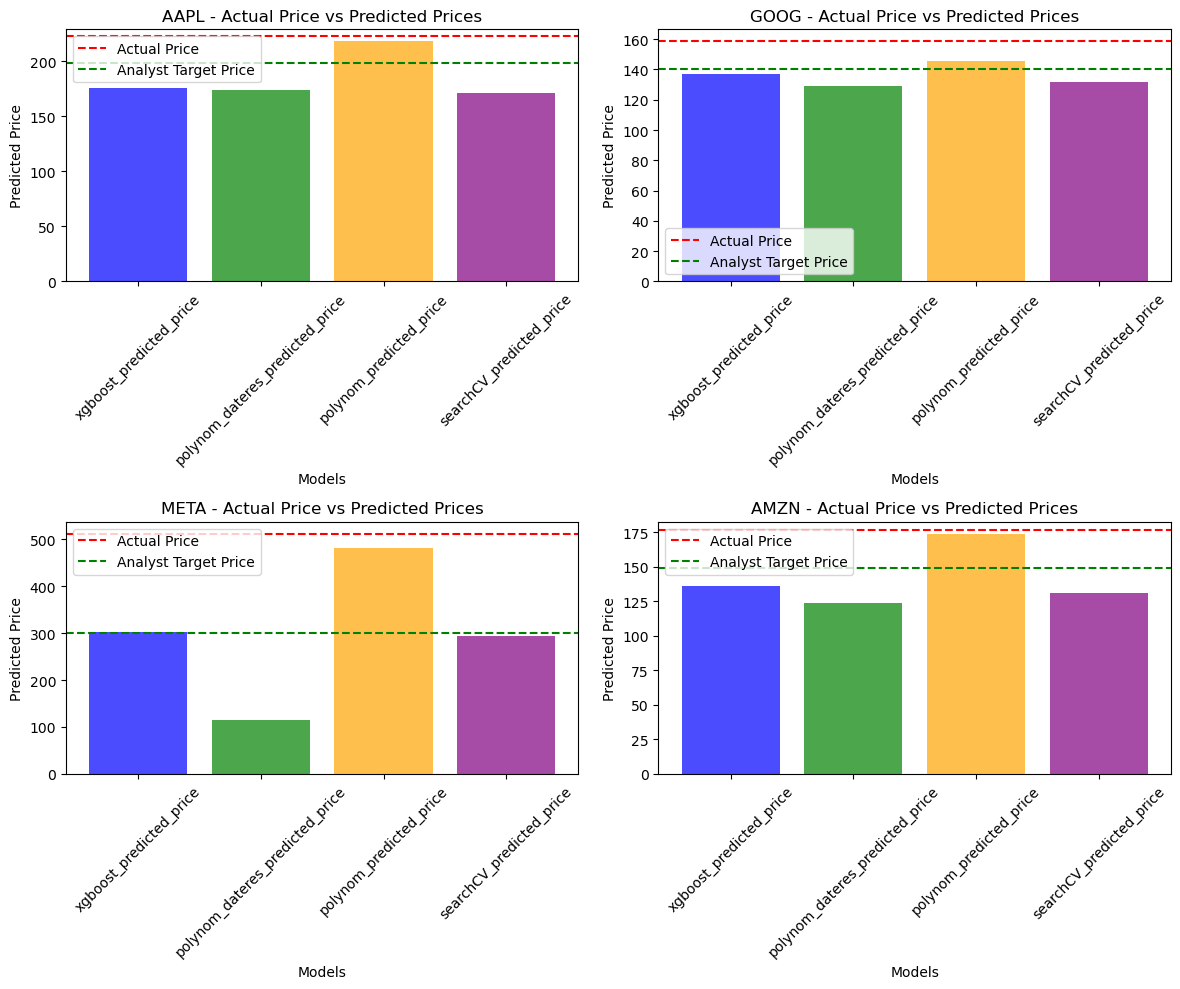

In [17]:
# Example data
xgboost_df = pd.DataFrame(xboost_results).rename(columns={'predicted_price': 'xgboost_predicted_price'})
polynom_dateres_df = pd.DataFrame(polynom_dateres_results).rename(columns={'predicted_price': 'polynom_dateres_predicted_price'})
polynom_df = pd.DataFrame(polynom_results).rename(columns={'predicted_price': 'polynom_predicted_price'})
searchCV_df = pd.DataFrame(searchCV_results).rename(columns={'predicted_price': 'searchCV_predicted_price'})

# Merge the DataFrames
merged_df = xgboost_df.merge(polynom_dateres_df[['symbol', 'target_date', 'polynom_dateres_predicted_price']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(polynom_df[['symbol', 'target_date', 'polynom_predicted_price']], on=['symbol', 'target_date'], how='left')
merged_df = merged_df.merge(searchCV_df[['symbol', 'target_date', 'searchCV_predicted_price']], on=['symbol', 'target_date'], how='left')

# Define the model names and colors for the bars
model_names = ['xgboost_predicted_price', 'polynom_dateres_predicted_price', 'polynom_predicted_price', 'searchCV_predicted_price']
colors = ['blue', 'green', 'orange', 'purple']

# Create subplots with a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate over the axes

# Iterate through each symbol and plot
for i, symbol in enumerate(merged_df['symbol'].unique()):
    
    symbol_data = merged_df[merged_df['symbol'] == symbol]
    
    predicted_prices = symbol_data[model_names].values.flatten()
    actual_price = symbol_data['actual_price'].values[0]
    analyst_target_price = symbol_data['analyst_target_price'].values[0]
    axes[i].bar(model_names, predicted_prices, color=colors, alpha=0.7)
    
    axes[i].axhline(y=actual_price, color='red', linestyle='--', label='Actual Price')
    
    axes[i].axhline(y=analyst_target_price, color='green', linestyle='--', label='Analyst Target Price')
    
    axes[i].set_title(f'{symbol} - Actual Price vs Predicted Prices')
    axes[i].set_xlabel('Models')
    axes[i].set_ylabel('Predicted Price')
    
    axes[i].tick_params(axis='x', rotation=45)
    
    axes[i].legend(['Actual Price', 'Analyst Target Price'])


plt.tight_layout()
plt.show()

# THE FINAL SOLUTION

Evaluating the models above, on balancethe model nearest the analyst price and price target is a XGBoost. 
The ifnal solution will be based on XGBoost and use Bayesian Optimisation to tune the hyperparameters.
In the code below I execute XGBoost, but this time I add in news sentiment scores, I will use the daily average, 3 month average and 1 month average.
I will also tune the hyperparameters using Bayesian Optimisation


In [18]:
#Load the sentiment data
sentiment_file_path = './data/average_sentiment_by_symbol_date.xlsx'
sentiment_df = pd.read_excel(sentiment_file_path)
sentiment_df['publishedOn'] = pd.to_datetime(sentiment_df['publishedOn'])
sentiment_df.rename(columns={'publishedOn': 'close_price_date', 'sentiment_score': 'average_sentiment'}, inplace=True)

# Merge the sentiment data with the price history data based on symbol and date
df_merged = pd.merge(df, sentiment_df[['symbol', 'close_price_date', 'average_sentiment']], on=['symbol', 'close_price_date'], how='left')
df_merged['average_sentiment'] = df_merged['average_sentiment'].fillna(0)
df_merged = df_merged.sort_values(by=['symbol', 'close_price_date'])  # Sort to ensure proper rolling calculation
df_merged['sentiment_3m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=90, min_periods=1).mean()).reset_index(level=0, drop=True)
df_merged['sentiment_1m_avg'] = df_merged.groupby('symbol')['average_sentiment'].apply(lambda x: x.rolling(window=30, min_periods=1).mean()).reset_index(level=0, drop=True)

df_train = df_merged[df_merged['close_price_date'] < train_cutoff_date]

# Define the function to optimize using Bayesian Optimization
def xgb_evaluate(n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'objective': 'reg:squarederror',
        'random_state': 42
    }    
    # Train the XGBoost model
    xgboost_model = xgb.XGBRegressor(**params)
    xgboost_model.fit(X_train_scaled, y_train)
    # Predict and calculate the error
    y_pred = xgboost_model.predict(X_test_scaled)
    return -mean_squared_error(y_test, y_pred)

# Define the hyperparameter space for Bayesian Optimization
pbounds = {
    'n_estimators': (100, 1000),
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),
    'min_child_weight': (1, 10),
    'gamma': (0, 5),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0)
}
    

# XGBoost regression for each stock symbol with sentiment
xgboost_results = []
symbols = df_train['symbol'].unique()

for symbol in symbols:
    # Filter data for the current symbol, using only data before 1st September 2023
    df_symbol = df_train[df_train['symbol'] == symbol].copy()

    # Add previous close price feature
    df_symbol['previous_close_price'] = df_symbol['close_price'].shift(1)
    df_symbol.dropna(inplace=True)

    # Select features and target, including 3-month and 1-month sentiment averages
    X = df_symbol[['day_of_week', 'month', 'year', 'previous_close_price', 'average_sentiment', 'sentiment_3m_avg', 'sentiment_1m_avg']]
    y = df_symbol['close_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize the Bayesian Optimizer
    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds=pbounds,
        random_state=42
    )

    # Optimize
    optimizer.maximize(init_points=5, n_iter=25)

    # Get the best hyperparameters
    best_params = optimizer.max['params']

    # Train the final model using the best parameters
    best_model = xgb.XGBRegressor(
        n_estimators=int(best_params['n_estimators']),
        learning_rate=best_params['learning_rate'],
        max_depth=int(best_params['max_depth']),
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        objective='reg:squarederror',
        random_state=42
    )
    best_model.fit(X_train_scaled, y_train)

    # Prepare input data for 3rd September 2024 prediction
    last_close_price = df_symbol['previous_close_price'].iloc[-1]  # Last available close price
    last_sentiment = df_symbol['average_sentiment'].iloc[-1]  # Last available sentiment score
    last_sentiment_3m = df_symbol['sentiment_3m_avg'].iloc[-1]  # Last 3-month sentiment average
    last_sentiment_1m = df_symbol['sentiment_1m_avg'].iloc[-1]  # Last 1-month sentiment average
    
    predict_date = pd.Timestamp('2024-09-03')
    predict_data = pd.DataFrame({
        'day_of_week': [predict_date.dayofweek],
        'month': [predict_date.month],
        'year': [predict_date.year],
        'previous_close_price': [last_close_price],
        'average_sentiment': [last_sentiment],
        'sentiment_3m_avg': [last_sentiment_3m],
        'sentiment_1m_avg': [last_sentiment_1m]
    })
    
    # Normalize the input features for prediction
    predict_data_scaled = scaler.transform(predict_data)

    # Predict the price
    predicted_price = best_model.predict(predict_data_scaled)[0]

    # Get the actual close price for 3rd September 2024, if available in the dataset
    actual_price = df.loc[(df['close_price_date'] == predict_date) & (df['symbol'] == symbol), 'close_price']
    actual_price = actual_price.values[0] if not actual_price.empty else None

    if actual_price is not None:
        predicted_percent_diff = ((predicted_price - actual_price) / actual_price) * 100
        analyst_percent_diff = ((analyst_targets[symbol] - actual_price) / actual_price) * 100
    else:
        predicted_percent_diff = None
        analyst_percent_diff = None

    # Collect results
    xgboost_results.append({
        'symbol': symbol,
        'target_date': '03/09/2024',
        'predicted_price': predicted_price,
        'analyst_target_price': analyst_targets[symbol],
        'actual_price': actual_price,
        'predicted_percent_diff': predicted_percent_diff,
        'analyst_percent_diff': analyst_percent_diff
    })

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | -128.0    | 0.7498    | 4.754     | 0.2223    | 7.191     | 2.404     | 240.4     | 0.6232    |
| 2         | -75.95    | 0.9465    | 3.006     | 0.2153    | 3.144     | 9.729     | 849.2     | 0.6849    |
| 3         | -157.3    | 0.6727    | 0.917     | 0.09823   | 6.673     | 4.888     | 362.1     | 0.8447    |
| 4         | -154.1    | 0.6558    | 1.461     | 0.1162    | 6.192     | 8.067     | 279.7     | 0.8057    |
| 5         | -109.3    | 0.837     | 0.2323    | 0.1862    | 4.194     | 1.585     | 954.0     | 0.9863    |
| 6         | -223.2    | 0.6       | 0.0       | 0.01      | 10.0      | 1.0       | 767.8     | 1.0       |
| 7         | -81.67    | 0.84      | 3.991     | 0.2013    | 3.142     | 9.713     | 849.5     | 0.9061    |
| 8       

## Output results in a table

In [19]:
formatted_df = pd.DataFrame(xgboost_results).style.format({
    'analyst_percent_diff': format_percentage,
    'predicted_percent_diff': format_percentage
})
display(formatted_df.set_caption("Sentiment Predicted Price Differences"))

,symbol,target_date,predicted_price,analyst_target_price,actual_price,predicted_percent_diff,analyst_percent_diff
0,AAPL,03/09/2024,174.941818,198,222.770000,-21.47%,-11.12%
1,AMZN,03/09/2024,135.834427,149,176.250000,-22.93%,-15.46%
2,GOOG,03/09/2024,137.034760,140,158.610000,-13.60%,-11.73%
3,META,03/09/2024,302.021637,300,511.760000,-40.98%,-41.38%


## Display the results in bar charts

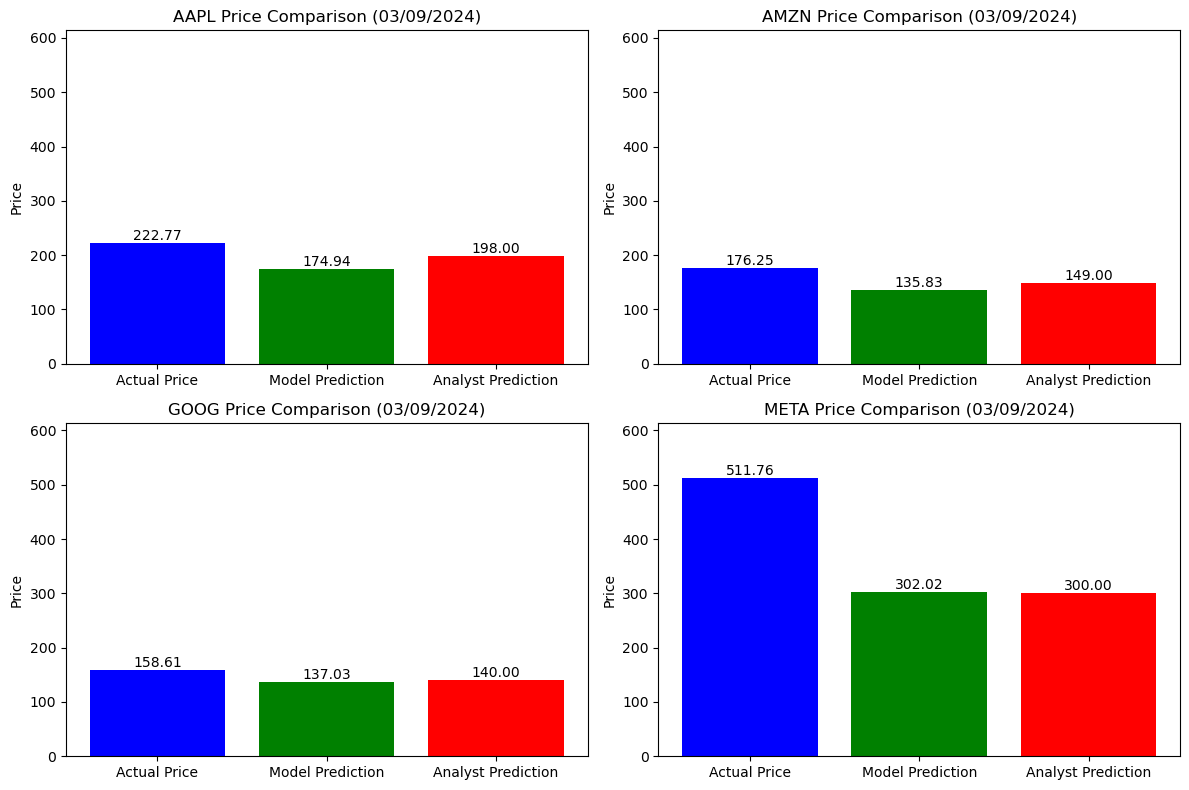

In [20]:
# grid for subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Symbols and results
symbols = [result['symbol'] for result in xgboost_results]
actual_prices = [result['actual_price'] for result in xgboost_results]
predicted_prices = [result['predicted_price'] for result in xgboost_results]
analyst_prices = [result['analyst_target_price'] for result in xgboost_results]

# Iterate over the symbols and plot each in a 2x2 grid
for idx, symbol in enumerate(symbols):
    ax = axes[idx // 2, idx % 2]
    
    # Data to be plotted
    categories = ['Actual Price', 'Model Prediction', 'Analyst Prediction']
    values = [actual_prices[idx], predicted_prices[idx], analyst_prices[idx]]
    
    # Bar plot for actual, predicted, and analyst prices
    bars = ax.bar(categories, values, color=['blue', 'green', 'red'])
    
    # Set title, labels, and limits
    ax.set_title(f'{symbol} Price Comparison (03/09/2024)')
    ax.set_ylabel('Price')
    ax.set_ylim([0, max(actual_prices + predicted_prices + analyst_prices) * 1.2])  # Set limit to accommodate highest bar
    
    # Add values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

## In summary this simple model has done rather well! I think future changes could be made to weight the sentiment scores to improve on the prices. But given the analyst predictions were an average across many analysts, some will be 20% more or less that the average  as an initial attempt this project shows there is potential.